In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta
from sklearn.metrics import mean_squared_error

water_flow_in_litre    133
dtype: int64
                     water_flow_in_litre  Water_Consumption
Rounded_Timestamp                                          
2024-01-01 12:00:00            1154000.0              400.0
2024-01-01 18:00:00            1157900.0             3900.0
2024-01-02 00:00:00            1157900.0                0.0
2024-01-02 06:00:00            1157900.0                0.0
2024-01-02 12:00:00            1162200.0             4300.0
2024-01-02 18:00:00            1178200.0            16000.0
2024-01-03 00:00:00            1189900.0            11700.0
2024-01-03 06:00:00            1190200.0              300.0
2024-01-03 12:00:00            1204600.0            14400.0
2024-01-03 18:00:00            1215400.0            10800.0
2024-01-04 00:00:00            1220140.0             4740.0
2024-01-04 06:00:00            1225300.0             5160.0
2024-01-04 12:00:00            1238000.0            12700.0
2024-01-04 18:00:00            1244500.0             6500.0


C:\Users\tamil\AppData\Local\Temp\ipykernel_8352\2410706728.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
C:\Users\tamil\AppData\Local\Temp\ipykernel_8352\2410706728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6h")
C:\Users\tamil\AppData\Local\Temp\ipykernel_8352\2410706728.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy

<Axes: xlabel='Rounded_Timestamp'>

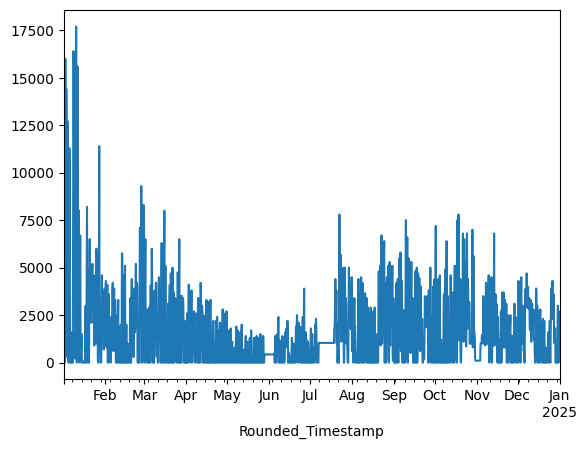

In [2]:
# Load dataset
water_usage = pd.read_csv('Water Usage/SOC Outlet-1/Table(1).csv',
                          usecols=["Date", "Time", "water_flow_in_litre", "water_flow_in_cubic_meter"])

# Reverse order if needed
data = water_usage[::-1]

# Set index and ensure DateTime format
data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d/%m/%Y %H:%M:%S")
data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6h")
#data = data.drop_duplicates(subset=["Rounded_Timestamp"], keep="first")  # Keep first occurrence
# Set the new Timestamp as index
data.set_index("Rounded_Timestamp", inplace=True)

# Drop the original "Date" and "Time" columns if no longer needed
data.drop(columns=["Date", "Time","Timestamp","water_flow_in_cubic_meter"], inplace=True)


# Ensure daily frequency
data = data.resample("6h").mean() 

# Rename column
#data.rename(columns={'water_flow_in_cubic_meter': 'Water_Consumption'}, inplace=True)
print(data.isna().sum())
data.interpolate(method="linear", inplace=True)

# Compute water consumption as the difference between consecutive water flow values
data["Water_Consumption"] = data["water_flow_in_litre"].diff()

# Drop the first row since it will have NaN (no previous value to subtract from)
data = data.dropna()

# Display first 20 rows
print(data.head(20))
data["Water_Consumption"].plot()

In [3]:

# Normalize the water consumption data
scaler = MinMaxScaler(feature_range=(0, 1))
data["Water_Consumption"] = scaler.fit_transform(data[["Water_Consumption"]])
original_timestamps = data.index  # Save timestamps before preprocessing

# Converts data into sequences for LSTM
def create_sequences(data, time_steps=10):
    """ Create input-output pairs for LSTM training. """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Use past 'time_steps' values as input
        y.append(data[i + time_steps])      # Predict the next value
    X, y = np.array(X), np.array(y)

    # Ensure 3D shape: (samples, time_steps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y

# Define time steps (e.g., past 7 readings)
time_steps = 7
data_values=data["Water_Consumption"].values
X, y = create_sequences(data_values, time_steps)

# Print shape (should be 3D: samples, time_steps, features)
print("X shape:", X.shape)  # (num_samples, time_steps, 1)
print("y shape:", y.shape)  # (num_samples,)




X shape: (1456, 7, 1)
y shape: (1456,)


In [4]:
# Define split index (80% training, 20% testing)
train_size = int(len(X) * 0.8)

# Split into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Verify final shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1164, 7, 1), y_train shape: (1164,)
X_test shape: (292, 7, 1), y_test shape: (292,)


In [5]:
def build_lstm_model(optimizer):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(7, 1)),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [6]:
optimizers = {
    "Adam": Adam(learning_rate=0.001),
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "RMSprop": RMSprop(learning_rate=0.001),
    "Adagrad": Adagrad(learning_rate=0.01),
    "Adadelta": Adadelta(learning_rate=1.0)
}

In [7]:
import matplotlib.pyplot as plt

def plot_training_loss(history, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')
    plt.legend()
    plt.show()

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Predict on test data
def pred(model, X_test, y_test, scaler, original_timestamps):
    predictions = model.predict(X_test)
    
    # Reverse scaling
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    predicted_timestamps = original_timestamps[-len(predictions):]  # Match predictions with time
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f"Test RMSE: {rmse:.2f}")
    acc=100*(1-(rmse/len(y_test)))
    print(f'Accuracy (ARIMA): {acc}')
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(predicted_timestamps,y_test_actual, label="Actual Water Demand")
    plt.plot(predicted_timestamps,predictions, label="Predicted Water Demand", linestyle="dashed")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Water Consumption")
    plt.title("LSTM Water Demand Forecasting")
    plt.show()


Training LSTM with Adam optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0178 - val_loss: 0.0068
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0068
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0152 - val_loss: 0.0066
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0066
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0066
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0147 - val_loss: 0.0067
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0130 - val_loss: 0.0069
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0136 - val_loss: 0.0067
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0128 - val_loss: 0.0064
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0127 - val_loss: 0.0063
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0113 - val_loss: 0.0063
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0125 - val_l

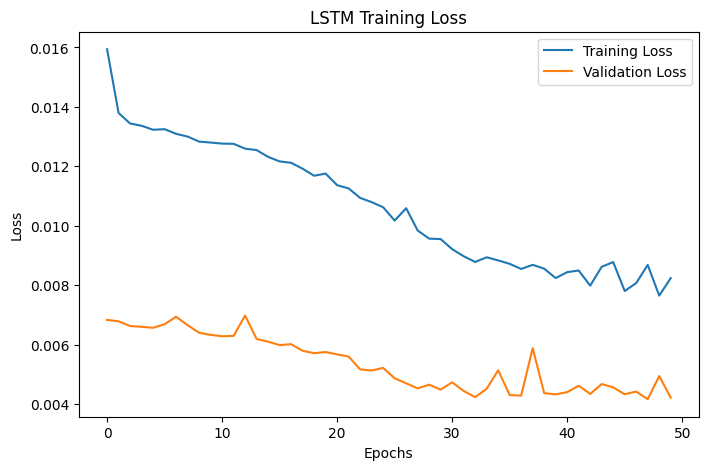

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step 
Test RMSE: 1150.03
Accuracy (ARIMA): -293.84479977816875


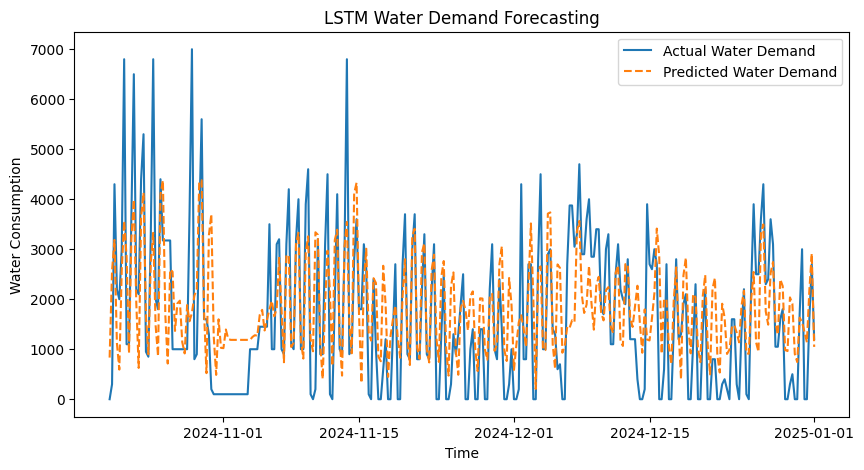


Training LSTM with SGD optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0216 - val_loss: 0.0072
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0149 - val_loss: 0.0072
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0072
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - val_loss: 0.0071
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0150 - val_loss: 0.0071
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0126 - val_loss: 0.0071
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - val_loss: 0.0071
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0154 - val_loss: 0.0071
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - val_loss: 0.0072
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0071
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0161 - val_loss: 0.0071
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157 - val_l

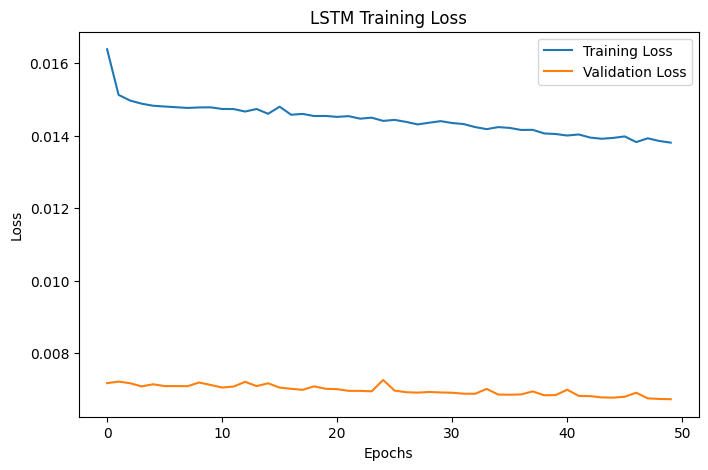

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step 
Test RMSE: 1452.45
Accuracy (ARIMA): -397.4132293151132


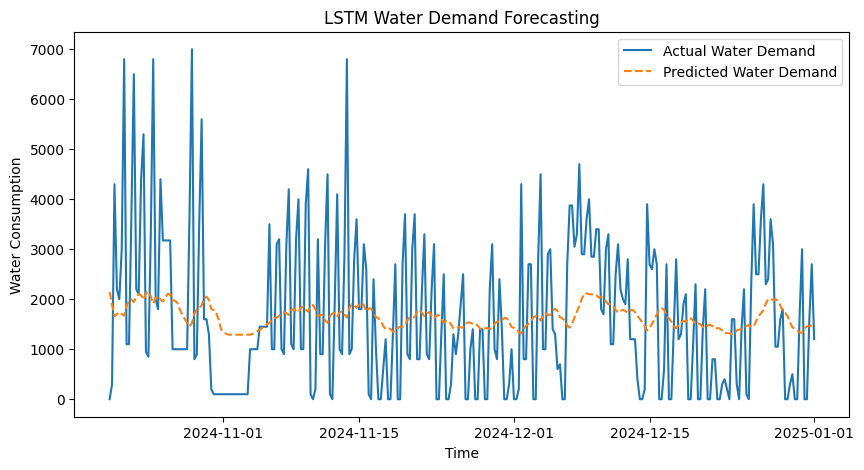


Training LSTM with RMSprop optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0176 - val_loss: 0.0071
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0161 - val_loss: 0.0068
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - val_loss: 0.0069
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0067
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0148 - val_loss: 0.0069
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0067
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0129 - val_loss: 0.0068
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123 - val_loss: 0.0068
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0132 - val_loss: 0.0066
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0131 - val_loss: 0.0072
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0119 - val_loss: 0.0072
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_l

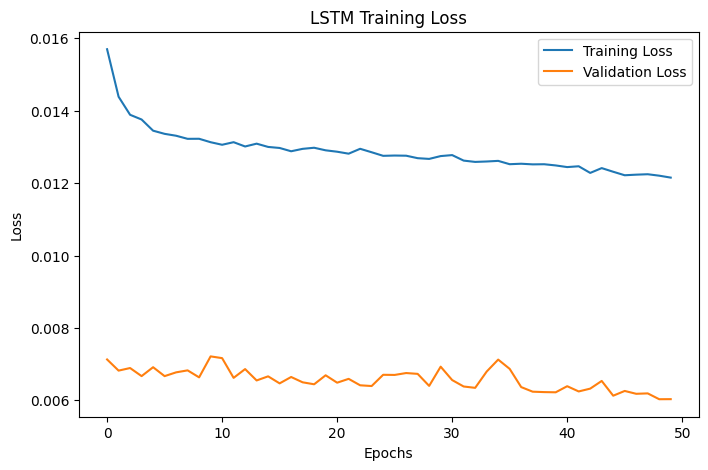

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step 
Test RMSE: 1374.56
Accuracy (ARIMA): -370.7394086204592


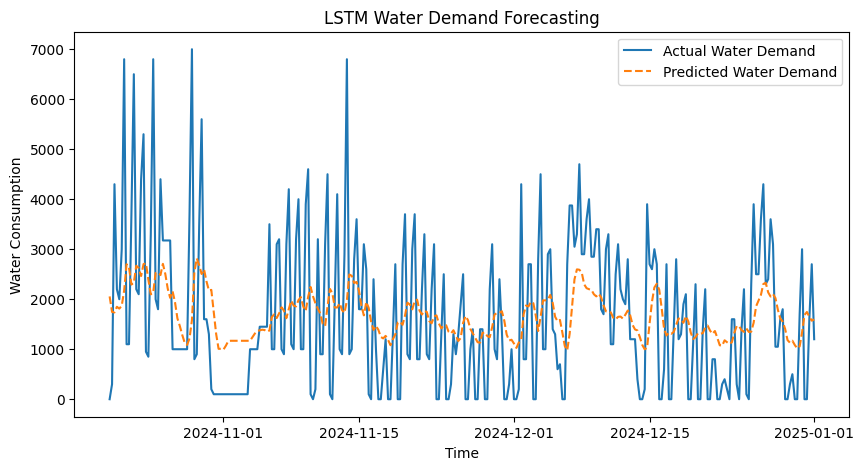


Training LSTM with Adagrad optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0180 - val_loss: 0.0072
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0173 - val_loss: 0.0071
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0139 - val_loss: 0.0071
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0138 - val_loss: 0.0071
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0144 - val_loss: 0.0071
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0151 - val_loss: 0.0071
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0071
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0071
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0071
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - val_loss: 0.0071
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0071
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_l

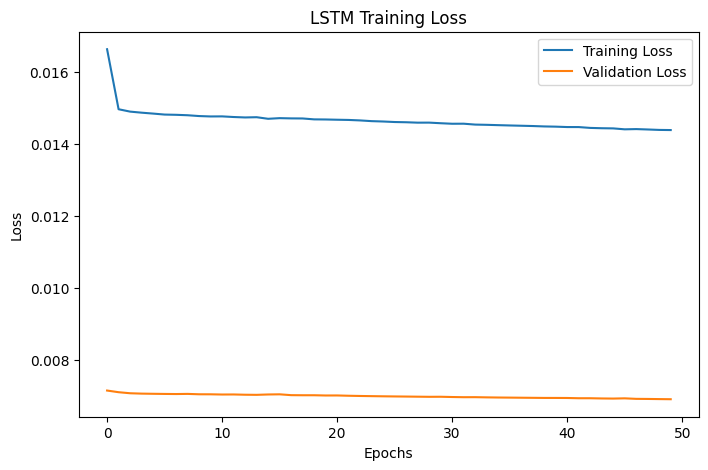

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step 
Test RMSE: 1472.63
Accuracy (ARIMA): -404.32648657818663


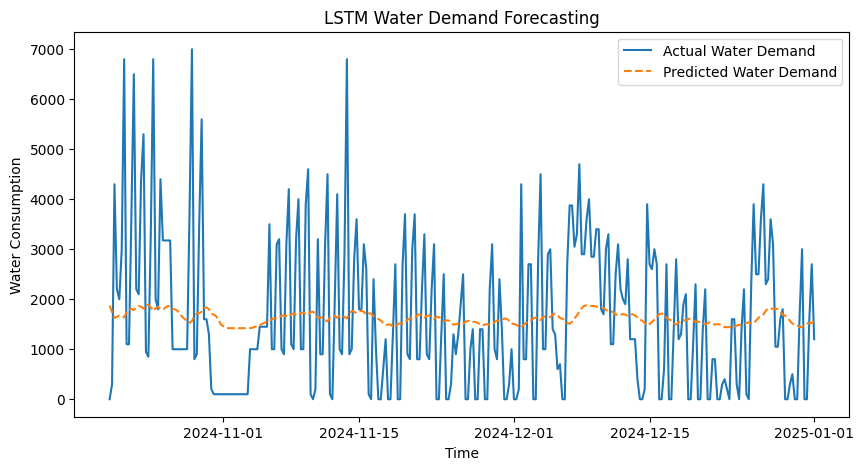


Training LSTM with Adadelta optimizer...
Epoch 1/50


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0214 - val_loss: 0.0072
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0147 - val_loss: 0.0074
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0128 - val_loss: 0.0070
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0146 - val_loss: 0.0067
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0119 - val_loss: 0.0077
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0138 - val_loss: 0.0069
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0159 - val_loss: 0.0068
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0153 - val_loss: 0.0066
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0137 - val_l

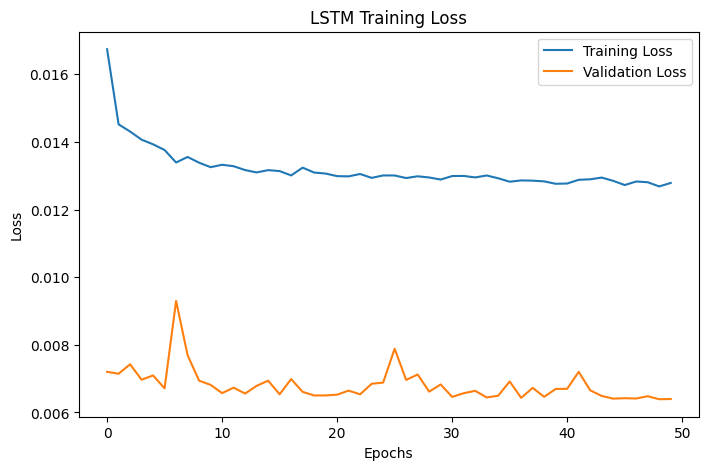

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step 
Test RMSE: 1415.61
Accuracy (ARIMA): -384.7973486027076


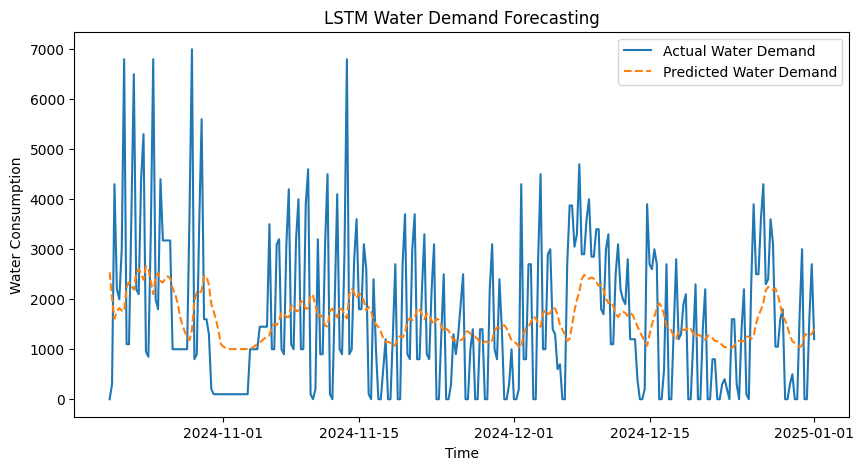

In [9]:
for name, opt in optimizers.items():
    print(f"\nTraining LSTM with {name} optimizer...")
    lstm_model = build_lstm_model(opt)
    history_lstm = lstm_model.fit(X_train, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(X_test, y_test), 
                              verbose=1)
    # Plot for LSTM
    plot_training_loss(history_lstm, "LSTM")
    pred(lstm_model,X_test,y_test,scaler,original_timestamps)